<a href="https://colab.research.google.com/github/Quang153636/quanghoang123-/blob/main/TTNT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# kết nối với thư mục trong drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# cài đặt các thư viện
!pip install split-folders
!pip install opencv-python
!pip install xmltodict
!pip install easyocr
!pip install gputil
!pip install numba

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.2/978.2 kB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 28.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=463a203f39dae568c5f12916971ecedc7b2a3602c968dc5b3dcc9bc387919262
  Stored in directory: /root/.cache/pip/wheels/92/a8/b7/d8a067c31a74de9ca252bbe53dea5f896faabd25d55f541037
Successfully built gputil


In [3]:
#Tiền xử lý dữ liệu

# Import thư viện cần thiết
import os
os.environ["OMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import cv2
import uuid
import time
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import xmltodict
import glob
import xml.etree.ElementTree as ET
import random as rnd
import shutil
import splitfolders
import easyocr

from PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split
from GPUtil import showUtilization as gpu_usage
from collections import Counter
from IPython import display
from google.colab.patches import cv2_imshow
from tqdm import tqdm
from tqdm.auto import tqdm
from PIL import Image
from timeit import default_timer as timer
from numba import cuda

import torch

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.image import imread
from matplotlib import patches as mpatches

import yaml


In [4]:
"""
mô tả, chú thích hình ảnh:
    - file: đường dẫn
    - width: rộng
    - height: cao
    - xmin, ymin, xmax, ymax: tọa độ biển số xe
"""
dataset = {
    "file": [],
    "width": [],
    "height": [],
    "xmin": [],
    "ymin": [],
    "xmax": [],
    "ymax": []
}

In [5]:
#Kiểm tra số lượng dataset đầu vào có ổn định hay không
img_names=[]
annotations=[]
for dirname, _, filenames in os.walk("/content/drive/MyDrive/TTNT/"): # Duyệt các file con nằm trong TTNT
    for filename in filenames:
        if os.path.join(dirname, filename)[-3:]=="jpg":     # Nếu là file.jpg thì add vào img_names . Ở đây chỉ sử dụng file ảnh .jpg cho dataset
            img_names.append(filename)
        elif os.path.join(dirname, filename)[-3:]=="xml":  # Kiểm tra file .xml : file dán nhẵn của các bức ảnh tương ứng
            annotations.append(filename)

print(len(img_names))
print(len(annotations))

399
389


In [6]:


path_annotations= "/content/drive/MyDrive/TTNT/annotations/*.xml"

for item in glob.glob(path_annotations): # Lặp qua từng file .xml và phân tích nội dung
    tree = ET.parse(item) # dùng thư viên để phân tích các file xml để thành 1 cây dữ liệu có thể duyệt qua

    for elem in tree.iter():
        if 'filename' in elem.tag:
            filename=elem.text
        elif 'width' in elem.tag:
            width=int(elem.text)
        elif 'height' in elem.tag:
            height=int(elem.text)
        elif 'xmin' in elem.tag:
            xmin=int(elem.text)
        elif 'ymin' in elem.tag:
            ymin=int(elem.text)
        elif 'xmax' in elem.tag:
            xmax=int(elem.text)
        elif 'ymax' in elem.tag:
            ymax=int(elem.text)
            # Lưu thông tin
            dataset['file'].append(filename)
            dataset['width'].append(width)
            dataset['height'].append(height)
            dataset['xmin'].append(xmin)
            dataset['ymin'].append(ymin)
            dataset['xmax'].append(xmax)
            dataset['ymax'].append(ymax)

classes = ['license']

df=pd.DataFrame(dataset) # Tạo file Pandas

df

,file,width,height,xmin,ymin,xmax,ymax
0,Cars1.jpg,275,183,93,114,179,136
1,Cars10.jpg,227,222,90,99,134,130
2,Cars100.jpg,318,158,172,58,210,79
3,Cars101.jpg,279,180,71,96,95,114
4,Cars102.jpg,275,183,50,130,97,142
...,...,...,...,...,...,...,...
393,Cars95.jpg,277,182,50,99,110,117
394,Cars96.jpg,275,183,106,142,168,151
395,Cars97.jpg,298,169,154,77,183,102
396,Cars98.jpg,246,205,111,113,146,139


In [7]:
# Hàm vẽ 1 khung bao quanh biển số xe với các giá trị đầu vào được xác định
def draw_border(img, pt1, pt2, color, thickness, r, d):

  x1, y1 = pt1
  x2, y2 = pt2

  #Hàm vẽ khuôn ảnh
  #Top left
  cv2.line(img, (x1 + r, y1), (x1 + r + d, y1), color, thickness)
  cv2.line(img, (x1, y1 + r), (x1, y1 + r + d), color, thickness)
  cv2.ellipse(img, (x1 + r, y1 + r), (r, r), 180, 0, 90, color, thickness)
  #Top right
  cv2.line(img, (x2 - r, y1), (x2 - r - d, y1), color, thickness)
  cv2.line(img, (x2, y1 + r), (x2, y1 + r + d), color, thickness)
  cv2.ellipse(img, (x2 - r, y1 + r), (r, r), 270, 0, 90, color, thickness)
  #Bottom left
  cv2.line(img, (x1 + r, y2), (x1 + r + d, y2), color, thickness)
  cv2.line(img, (x1, y2 - r), (x1, y2 - r - d), color, thickness)
  cv2.ellipse(img, (x1 + r, y2 - r), (r, r), 90, 0, 90, color, thickness)
  #Bottom right
  cv2.line(img, (x2 - r, y2), (x2 - r - d, y2), color, thickness)
  cv2.line(img, (x2, y2 - r), (x2, y2 - r - d), color, thickness)
  cv2.ellipse(img, (x2 - r, y2 - r), (r, r), 0, 0, 90, color, thickness)

In [8]:
#Hàm để random ra ngẫu nhiên 4 bức ảnh để test xem dataset đã ổn chưa , chức năng của hàm vẽ khung
def showRandomImage(photos):
  fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize=(15,5))
  random_photos = rnd.sample(photos, 4)                                 #Ramdom ra 4 ảnh ngẫu nhiên
  for plot_index, image_path in enumerate(random_photos):
    for index, file in enumerate(df.file):                              #Duyệt qua các file xml lưu trong df
      if image_path.split("/")[-1] == file:                             #So sánh để tìm được file xml tương ứng với bức ảnh
        information = list(df.iloc[index, -4:])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        draw_border(image, (information[0], information[1]), (information[2], information[3]), (255, 0, 0), 3, 5, 10)
        ax[plot_index].imshow(image)
  plt.show()

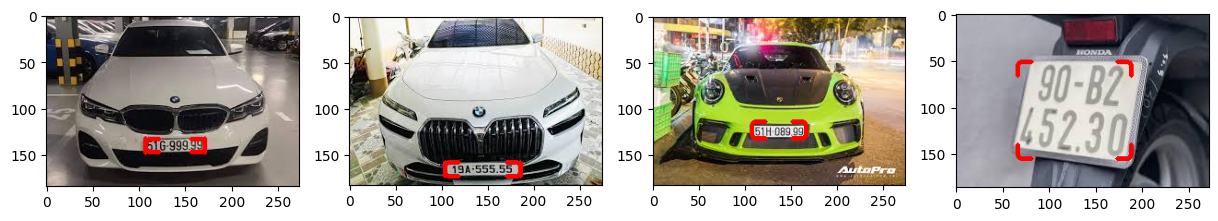

In [9]:
#Thực hiện việc show 4 bức ảnh ngẫu nhiên
photo_path = "/content/drive/MyDrive/TTNT/images/*.jpg"
photo_list = glob.glob(photo_path)
showRandomImage(photo_list)

In [10]:
#Mô tả Yolo yêu cầu dữ liệu chuẩn hóa trong khoản (0,1)
# Ở định dạng [class_id, x, y, rộng, cao] trong đó x,y là tọa độ hộp giới hạn
#Với chiều rộng và chiều cao tương ứng
#Dữ liệu tính toán được lưu dưới dạng tệp .txt có tên tương ứng với các bức ảnh

x_pos = []
y_pos = []
frame_width = []
frame_height = []

#Tạo thư mục lables : nhãn của mỗi ảnh
labels_path = Path("/content/drive/MyDrive/TTNT/labels")
labels_path.mkdir(parents=True, exist_ok=True)

#Tạo file đánh nhãn tại thư mục lables
save_type = 'w'
for i, row in enumerate(df.iloc):
  current_filename = str(row.file[:-4])

  width, height, xmin, ymin, xmax, ymax = list(df.iloc[i, -6:])

  x = (xmin + xmax) / (2 * width)
  y = (ymin + ymax) / (2 * height)
  w = (xmax - xmin) / width
  h = (ymax - ymin) / height

  x_pos.append(x)
  y_pos.append(y)
  frame_width.append(w)
  frame_height.append(h)

  txt = '0' + ' ' + str(x) + ' ' + str(y) + ' ' + str(w) + ' ' + str(h) + '\n'

  if i > 0:
    previous_filename = str(df.file[i-1][:-4])
    save_type = 'a+' if current_filename == previous_filename else 'w'

  with open("/content/drive/MyDrive/TTNT/labels/" + str(row.file[:-4]) + '.txt', save_type) as f:
    f.write(txt)

df['x_pos'] = x_pos
df['y_pos'] = y_pos
df['frame_width'] = frame_width
df['frame_height'] = frame_height

In [11]:
df.head(5)

,file,width,height,xmin,ymin,xmax,ymax,x_pos,y_pos,frame_width,frame_height
0,Cars1.jpg,275,183,93,114,179,136,0.494545,0.683060,0.312727,0.120219
1,Cars10.jpg,227,222,90,99,134,130,0.493392,0.515766,0.193833,0.139640
2,Cars100.jpg,318,158,172,58,210,79,0.600629,0.433544,0.119497,0.132911
3,Cars101.jpg,279,180,71,96,95,114,0.297491,0.583333,0.086022,0.100000
4,Cars102.jpg,275,183,50,130,97,142,0.267273,0.743169,0.170909,0.065574


In [12]:
#Trước tiên truy cập link YoloV5
#Clone Repo để cùng với thư mục dataset
#Sử dụng Splitfolder chia bộ dataset thành 2 tập train và validation

%cd "/content/drive/MyDrive/TTNT"
!git clone https://github.com/ultralytics/yolov5.git

/content/drive/MyDrive/TTNT
Cloning into 'yolov5'...
remote: Enumerating objects: 17757, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 17757 (delta 73), reused 39 (delta 39), pack-reused 17639 (from 4)
Receiving objects: 100% (17757/17757), 17.11 MiB | 17.15 MiB/s, done.
Resolving deltas: 100% (12060/12060), done.


In [13]:
#Di chuyển dataset
#Chuyển các folder của dataset gốc đến foler mới theo địa chỉ yolov5/data/TTNT/
input_folder = Path("/content/drive/MyDrive/TTNT/")
output_folder = Path("yolov5/data/TTNT")
splitfolders.ratio(
    input_folder,
    output_folder,
    seed=42,
    ratio=(0.8, 0.2),
    group_prefix=None
)


Copying files: 1191 files [00:16, 70.48 files/s]


In [14]:
#YoloV5 yêu cầu một file đó là file .yaml nhằm giúp cho YoloV5 lúc train xác định được class
# Cần dự đoán, file train nằm ở đâu, file test, validation nằm ở đâu

#Tạo file .yaml
yaml_file = '/content/drive/MyDrive/TTNT/yolov5/data/plates.yaml'

yaml_data = dict(
    path = '/content/drive/MyDrive/TTNT/yolov5/data/TTNT',
    train = 'train/images',
    val = 'val/images',
    nc = len(classes),
    names = classes
)

with open(yaml_file, 'w') as f:
    yaml.dump(yaml_data, f,explicit_start = True, default_flow_style=False)


"""
Cấu trúc file yaml
---
names:
- license
nc: 1
path: /content/drive/MyDrive/TTNT/yolov5/data/TTNT
train: train/images
val: val/images
"""

'\nCấu trúc file yaml\n---\nnames:\n- license\nnc: 1\npath: /content/drive/MyDrive/TTNT/yolov5/data/TTNT\ntrain: train/images\nval: val/images\n'

In [15]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 40.0 MB/s eta 0:00:00


In [16]:
start_time = timer()         # lấy thời gian bắt đầu
%cd "/content/drive/MyDrive/TTNT/yolov5"
!python "/content/drive/MyDrive/TTNT/yolov5/train.py" --workers 2 --img 640 --batch 16 --epochs 100 --data "/content/drive/MyDrive/TTNT/yolov5/data/plates.yaml" --weights yolov5s.pt --device 0 --cache

end_time = timer()            # Lấy thời gian kết thúc

print(f"Train Time : {(end_time - start_time):.2f}")  #Tính toán thời gian train YoloV5

/content/drive/MyDrive/TTNT/yolov5
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-12-14 03:27:03.965087: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765682823.984430    3039 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765682823.990228    3039 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to re

In [17]:
torch.amp.autocast('cuda')


In [18]:
## load model
model = torch.hub.load('ultralytics/yolov5', 'custom',
                       path='/content/drive/MyDrive/TTNT/yolov5/runs/train/exp/weights/best.pt', force_reload=True)

## chọn ngôn ngữ của biển số xe
reader = easyocr.Reader(['en','vi'])

/usr/local/lib/python3.12/dist-packages/torch/hub.py:335: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(


Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


YOLOv5 🚀 2025-12-14 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:898: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Photo width, height: 282, 216, Detected plates: 1
Detection 1: YOLOv5 prob = 0.73, OCR = B0E92291


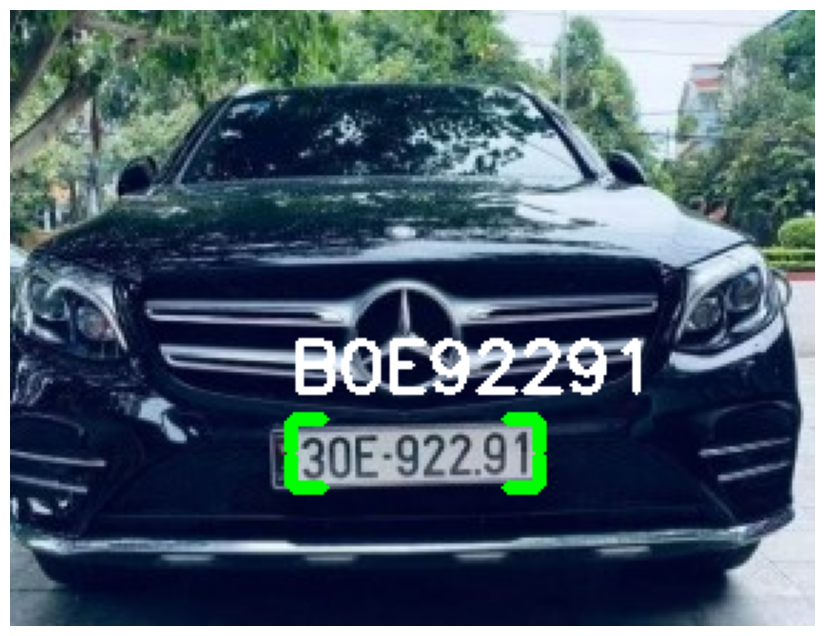

In [20]:

from matplotlib import rcParams
import matplotlib.pyplot as plt
%matplotlib inline

rcParams['figure.figsize'] = (12, 8)

#Đường dẫn lấy ảnh test
test_photo_path = "/content/drive/MyDrive/TTNT/ImageTest/test01.jpg"

# Dùng model YOLO để detect biển số
result = model(test_photo_path)            #Gọi mô hình huấn luyện YoloV5 để lấy các thông tin tọa độ, độ tin cậy
image = cv2.imread(test_photo_path)         #đọc ảnh từ file đọc theo định dạng BGR
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)        #Chuyển từ BGR sang RGB

width, height = image.shape[1], image.shape[0]                  # lấy chiều rộng , chiều cao của ảnh
labels, coordinates = result.xyxyn[0][:, -1], result.xyxyn[0][:, :-1]   # tách nhãn dự đoán và tọa độ

print(f"Photo width, height: {width}, {height}, Detected plates: {len(labels)}")

for i in range(len(labels)):      # Duyệt qua các nhãn (biển số) phát hiện được
    row = coordinates[i]
    confidence = row[4]           # Lấy độ tin cậy
    if confidence >= 0.5:         #Kiểm tra độ tin cậy
        x1, y1, x2, y2 = int(row[0]*width), int(row[1]*height), int(row[2]*width), int(row[3]*height) # Chuyển đổi tạo độ chuẩn hóa sang tọa độ pixel thực tế

        # Kiểm tra tọa độ không vượt quá kích thước ảnh
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(width, x2), min(height, y2)

        plate_crop = image[y1:y2, x1:x2]

        # Tiền xử lý ảnh trước OCR để tăng độ chính xác
        gray = cv2.cvtColor(plate_crop, cv2.COLOR_RGB2GRAY)       # Chuyển ảnh sang màu xám
        blur = cv2.GaussianBlur(gray, (3, 3), 0)                  #Làm mờ ảnh
        thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 11, 2)         #Phân ngưỡng ảnh xám thánh ảnh nhị phân đen / trắng

        # Đọc chữ bằng EasyOCR
        ocr_result = reader.readtext(thresh, paragraph=True, min_size=20, allowlist='0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ-.')
        if ocr_result:
            text = " ".join([line[1] for line in ocr_result])
        else:
            text = "No Text"

        # Vẽ khung và ghi kết quả
        draw_border(image, (x1, y1), (x2, y2), (0, 255, 0), 3, 1, 10) #vẽ khung
        cv2.putText(image, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)    # ghi kết quả lên hình ảnh

        print(f"Detection {i + 1}: YOLOv5 prob = {confidence:.2f}, OCR = {text}")

# Hiển thị kết quả
plt.figure(figsize=(12, 8))
plt.axis('off')
plt.imshow(image)
plt.show()